# Python with Fortran

Author: Ryota Higa

Reference

> http://d.hatena.ne.jp/ignisan/20121017/p1

> http://www.nag-j.co.jp/fortran/tips/tips_InteroperabilityWithC.html#MixCF

> http://fortran66.hatenablog.com/entry/2014/02/26/021624

# Fortran control by Jupyter-notebook

In [1]:
%%writefile test.f90
program test
    implicit none
    integer i, j
    do i = 1, 3
        do j = 1, 3
        write(*, *) i, j, i+j
        end do
    end do
end program

Overwriting test.f90


In [2]:
!gfortran test.f90

In [3]:
!./a.out

           1           1           2
           1           2           3
           1           3           4
           2           1           3
           2           2           4
           2           3           5
           3           1           4
           3           2           5
           3           3           6


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from ctypes import * 
%matplotlib inline

# Fortran, add.f90

In [5]:
%%writefile add.f90
subroutine add(a,b)
    implicit none
    integer(8),intent(in) :: a
    integer(8),intent(inout):: b
    b = a + b
end subroutine

Overwriting add.f90


## Compile 

In [6]:
!gfortran -shared -fPIC -o add.so add.f90

## Call from Python

In [7]:
addmodule = cdll.LoadLibrary("add.so")

# 引数の型を指定する。今回はintのポインタ型
# Fortranのサブルーチン名"add"にアンスコ"_"をつける(gccでは)
addmodule.add_.argtypes = [ POINTER(c_int64),POINTER(c_int64)]
      
# 戻り値の型を指定する。Fortranのサブルーチンはvoidしか返せない
addmodule.add_.restype = c_void_p  

# 呼び出しに使う引数はctypesの型でラップする
a,b = 10,8 
a = c_int64(a)
b = c_int64(b)
 
# byrefでポインタにして渡す         
addmodule.add_(byref(a),byref(b)) 
print b.value # 18 

18


# add_np.f90

In [8]:
%%writefile add_np.f90
#define MAXSIZE 1024 
subroutine add_array(a,b,N)
    implicit none
    integer(8),intent(in) :: N  
    real(8),dimension(0:MAXSIZE),intent(in) :: a
    real(8),dimension(0:MAXSIZE),intent(inout):: b
#ifndef NDEBUG
    if (N>MAXSIZE) then
        print *,"MAXSIZE is too small."
    endif 
#endif 
    b(0:N-1) = b(0:N-1) + a(0:N-1)
end subroutine

Overwriting add_np.f90


## Compile

In [9]:
!gfortran -cpp -shared -fPIC -o add_np.so add_np.f90

## Call from Python

In [10]:
from ctypes import *
import numpy as np

add_np = np.ctypeslib.load_library("add_np.so",".")
add_np.add_array_.argtypes = [
               np.ctypeslib.ndpointer(dtype=np.float64),
               np.ctypeslib.ndpointer(dtype=np.float64),
               POINTER(c_int64),]
add_np.add_array_.restype = c_void_p   
                    
a = np.arange(0.,10.,dtype=np.float64) # 0,1,2,3,4,5,..,9 
b = a*2                                # 0,2,4,6,8,...,18
size = byref(c_int64(b.size)) 
add_np.add_array_(a,b,size) # ndarrayはそのまま渡して良い 
print b # [ 0 3 6 9 12 .. 27 ] 

[  0.   3.   6.   9.  12.  15.  18.  21.  24.  27.]


# D_py.f90

In [11]:
%%writefile D_py.f90
module m_test
  implicit none
  real(8), parameter :: pi = 4 * atan(1.0d0)
contains    
  subroutine test(n, x) BIND(c, name = 'test')
    !DEC$ ATTRIBUTES DLLEXPORT :: test
    integer, value :: n
    real(8), intent(out) :: x(n)
    integer :: i
    print *,'n = ',n
    do i = 1, n
      x(i) = sin( (i - 1) * pi / (n - 1) )
    end do  
  end subroutine test
end module m_test

Overwriting D_py.f90


In [12]:
!gfortran -shared -o D_py.dll D_py.f90

In [13]:
my_mod = CDLL("D_py.dll")
my_mod.test.argtypes = [
               c_int32,
               np.ctypeslib.ndpointer(dtype=np.float64)]
my_mod.test.restype = c_void_p

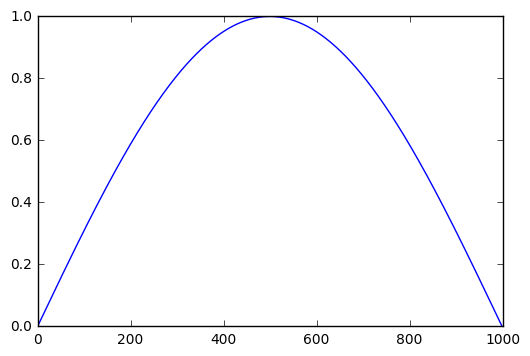

In [14]:
x = np.arange(0.0, 1000.0, dtype=np.float64)
my_mod.test(x.size, x)  
plt.plot(x)
plt.show()